In [1]:
import os
import glob

from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.io import read_image

from ignite.engine import Engine
from ignite.metrics import Accuracy

In [4]:
labels = pd.read_csv('labels.csv')
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [37]:
labels = labels.assign(breed_id=labels['breed'].astype('category').cat.codes)
labels
idx_to_class_name = dict(zip(labels['breed_id'], labels['breed']))
idxs, names = zip(*sorted(list(idx_to_class_name.items()), key=lambda x: x[0]))
txt = '\n'.join(names)
with open('labels.txt', 'w') as f:
    f.write(txt)

In [39]:
train_labels = labels.sample(frac=0.8)
val_labels = labels.drop(train_labels.index)
train_labels.to_csv('train.csv')
val_labels.to_csv('val.csv')

In [10]:
class DogImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        labels = pd.read_csv(annotations_file)
        self.img_labels = labels.assign(breed_id=labels['breed'].astype('category').cat.codes)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]['id'] + '.jpg')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]['breed_id']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ConvertImageDtype(torch.float),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ConvertImageDtype(torch.float),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = DogImageDataset('train.csv', 'train', transform=data_transforms['train'])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
train_imgs, train_labels = next(iter(train_loader))
train_imgs.shape, train_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [6]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
n_classes = len(labels['breed'].unique())
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to('cuda:0')

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [44]:
model.train()
n_epochs = 20

losses = []
for i in range(n_epochs):
    for x, y in tqdm(iter(train_loader), total=len(train_loader)):
        x, y = x.to('cuda:0'), y.to('cuda:0').long()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

100%|██████████| 64/64 [00:37<00:00,  1.71it/s]


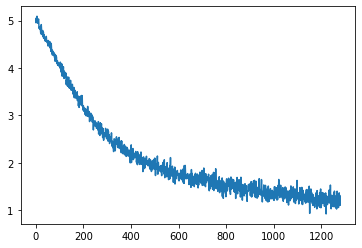

In [45]:
plt.plot(losses)

In [46]:
torch.save(model.state_dict(), 'model.pth')

In [33]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [35]:
val_data = DogImageDataset('val.csv', 'train', transform=data_transforms['train'])
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

Evaluate the model on validation data

In [49]:
model.eval()
correct = 0
for x, y in tqdm(iter(val_loader), total=len(val_loader)):
    x, y = x.to('cuda:0'), y.to('cuda:0').long()
    y_pred = model(x)
    y_pred_class = torch.argmax(y_pred, dim=1)
    correct += torch.sum(y_pred_class == y).item()
print(f'Validation accuracy: {100 * correct / len(val_data)}%')

100%|██████████| 32/32 [00:07<00:00,  4.15it/s]

Validation accuracy: 67.41682974559687%


Eval using PyTorch-Ignite

In [34]:
def process_function(engine, batch):
    x, y = batch
    x, y = x.to('cuda:0'), y.to('cuda:0').long()
    y_pred = model(x)
    
    return y_pred, y

engine = Engine(process_function)
metric = Accuracy()
metric.attach(engine, "accuracy")

In [36]:
model.eval()
state = engine.run(val_loader, 1)
print(f"Accuracy: {state.metrics['accuracy']}")

Accuracy: 0.675146771037182


(16, [<matplotlib.lines.Line2D at 0x7f955b22d810>])

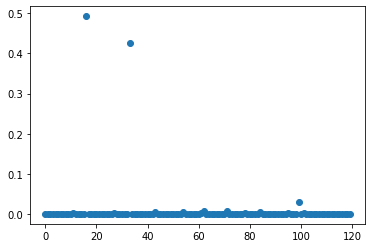

In [21]:
model.eval()
img = read_image('border_2.jpeg')
x = data_transforms['val'](img).unsqueeze(0).to('cuda:0')

y_pred = model(x).squeeze(0)
class_label = y_pred.argmax().item()
class_label, plt.plot(torch.softmax(y_pred, 0).detach().cpu(), 'o')

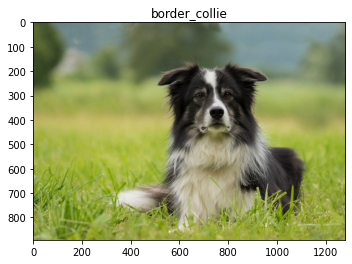

In [131]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(idx_to_class_name[class_label])
None

Wrap the model with permutation of input data and softmax at the output for mobile use as it expects N x H x W x C input tensor and class probability at the output.

In [30]:
class Net(nn.Module):
    def __init__(self, resnet):
        super().__init__()
        self.resnet = resnet
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        return self.softmax(self.resnet(torch.permute(x, (0, 3, 1, 2))))
    
net = Net(model)
net.eval()
None

Export the model to onnx

In [31]:
img = read_image('border_2.jpeg')
x = data_transforms['val'](img).unsqueeze(0).to('cuda:0')
x = x.permute(0, 2, 3, 1)
torch.onnx.export(net, x, 'dogs.onnx', opset_version=10)